## Проект: Обучение с учителем: качество модели

**Описание проекта** 
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Для начала импортируем библиотеки**

**Далее нам нужно будет загрузить данные и изучить данные:**

1.1 Загрузим данные. Файлы `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`

1.2 Проверим, что данные в таблицах соответствуют описанию. 

**Далее нужно предобработать данные:**

2.1 Проведем необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

**Далее нужно провести исследовательский анализ данных:**

3.1 Проведем исследовательский анализ данных из каждой таблицы. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформим выводы по результатам шага.

**Далее объединим таблицы:**

4.1 Объединим таблицы `market_file.csv`, `market_money.csv`, `market_time.csv`. Данные о прибыли из файла `money.csv` при моделировании нам не понадобятся. 

4.2 Учитываем, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

**Далее проведем корелляционный анализ:**

5.1 Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

**Далее используем пайплайны:**

6.1 Во время подготовки данных используем `ColumnTransformer`. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков используем как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

6.2 Обучим четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и  `SVC()`. Для каждой из них подберем как минимум один гиперпараметр. Выберем подходящую для задачи метрику, аргументируем свой выбор. Используем эту метрику при подборе гиперпараметров.

6.3 Выберем лучшую модель, используя заданную метрику.

**Проведем анализ важности признаков:**

7.1 Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

7.2 Сделаем выводы о значимости признаков.

**Далее проведем сегментацию покупателей:**

8.1 Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей.

8.2 Выберем группу покупателей и предложим, как увеличить её покупательскую активность.

8.3 Сделаем выводы о сегментах.

**Далее сделаем итоговые выводы:**

9.1 Опишем задачу.

9.2 Опишем исходные данные и проведённую предобработку.

9.3 Напишем, что сделали для поиска лучшей модели.

9.4 Укажем лучшую модель

9.5 добави выводы и дополнительные предложения для выбранного сегмента покупателей.

**Импортируем библиотеки и пакеты:**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.prefix)

!pip install phik -q
!pip install shap -q
!pip install --upgrade scikit-learn -q
!pip install --upgrade pandas==1.5.0 -q

/opt/conda


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas  as pd
import phik
import seaborn as sns
import shap

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
                        
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Шаг 1. Загрузка данных

**1.1 Загрузим данные. Файлы `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`**

**Загрузим `market_file.csv`:**

In [3]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Загрузим `market_money.csv`:**

In [4]:
try:
    market_money = pd.read_csv('/datasets/market_money.csv')
except:
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


**Загрузим `market_time.csv`:**

In [5]:
try:
    market_time = pd.read_csv('/datasets/market_time.csv')
except:
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


**Загрузим `money.csv`:**

In [6]:
try:
    money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')
except:
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal = ',')
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Вывод**

Данные загружены и проверенны на соответствие описанию. Далее приступаем к предобработке.

## Шаг 2. Предобработка данных:

**2.1 Проведем необходимую предобработку данных. Названия столбцов можно оставить кириллическими.** 

**Предобработка `market_file`:**

In [7]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Изменим название столбцов и исправим данные:

In [8]:
market_file.columns = map(str.lower, market_file.columns)
market_file.columns = market_file.columns.str.replace(' ', '_')
market_file["тип_сервиса"] = market_file["тип_сервиса"].replace(['стандартт'],'стандарт')
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Проверим уникальные значения и типы данных:

In [9]:
display(market_file["покупательская_активность"].unique())
display(market_file["разрешить_сообщать"].unique())
display(market_file["популярная_категория"].unique())
display(market_file["тип_сервиса"].unique())
market_file.dtypes

array(['Снизилась', 'Прежний уровень'], dtype=object)

array(['да', 'нет'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

array(['премиум', 'стандарт'], dtype=object)

id                                       int64
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object

Изменим типы данных:

In [10]:
market_file["маркет_актив_6_мес"] = market_file["маркет_актив_6_мес"].astype(float) 
market_file["акционные_покупки"] = market_file["маркет_актив_6_мес"].astype(float)
market_file.dtypes

id                                       int64
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object

Далее проверим явные дубликаты:

In [11]:
print('Явных дубликатов:', market_file.duplicated().sum())

Явных дубликатов: 0


In [12]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

**Предобработка `market_money`:**

In [13]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Проверим уникальные значения:

In [14]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Далее проверим столбцы, типы данных и явные дубликаты:

In [15]:
market_money.columns = map(str.lower, market_money.columns)

market_money.dtypes

id           int64
период      object
выручка    float64
dtype: object

In [16]:
market_money["выручка"] = market_money["выручка"].astype(float)
market_money.dtypes

id           int64
период      object
выручка    float64
dtype: object

In [17]:
market_money.duplicated().sum()

0

In [18]:
market_money = market_money.drop_duplicates().reset_index(drop=True)
print('Явных дубликатов:', market_money.duplicated().sum())

Явных дубликатов: 0


In [19]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Предобработка `market_time`:**

In [20]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Изменим столбцы, проверим типы данных и проверим явные дубликаты:

In [21]:
market_time.columns = map(str.lower, market_time.columns)
display(market_time.head())
market_time['период'].unique()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [22]:
market_time["период"] = market_time["период"].replace(['предыдцщий_месяц'],'предыдущий_месяц')
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [23]:
print('Явных дубликатов:', market_time.duplicated().sum())

Явных дубликатов: 0


In [24]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Предобработка `money`:**

In [25]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Изменим столбцы, проверим типы данных и проверим явные дубликаты:

In [26]:
money.columns = map(str.lower, money.columns)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [27]:
print('Явных дубликатов:', money.duplicated().sum(), '\n')

Явных дубликатов: 0 



In [28]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


***Вывод по предобработке данных***

В представленных данных пропуски не обнаружены

Произведено изменение названий столбцов:
- перевод в строчный формат
- замена пробелов на подчеркивание

В `market_file` 
- в колонке `тип_сервиса` данные `стандартт` заменены на `стандарт`
- изменены типы стоблцов `маркет_актив_6_мес` на `float`, и `акционные_покупки` на `float`

В `market_money`
- в колонке `период`данные `препредыдущий_месяц` заменены на `предыдущий_месяц`
- изменен тип столбца `выручка` на `float`
- проведено удаление пяти полных дубликатов

В `market_time`
- в колонке `период` данные `предыдцщий_месяц` заменены на `предыдущий_месяц`

## Шаг 3. Исследовательский анализ данных

**3.1 Проведем исследовательский анализ данных из каждой таблицы. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформим выводы по результатам шага.**

**Анализ строковых значений `market_file`:**

In [29]:
market_file.describe(include='object')

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1300,1300,1300,1300
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,924,962,330


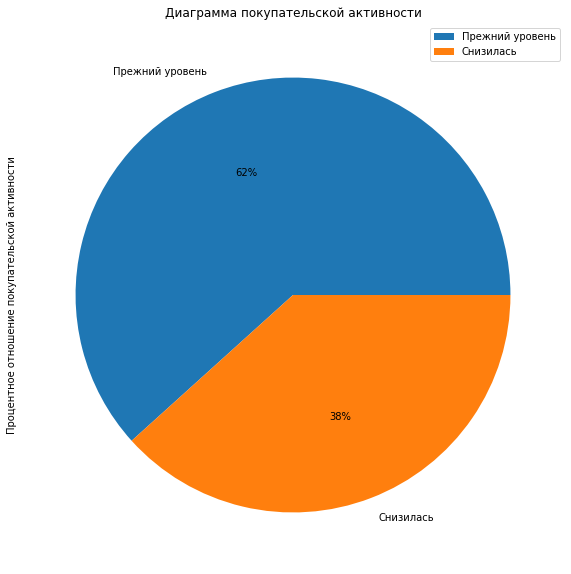

In [30]:
(
market_file
    .pivot_table(index='покупательская_активность',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), 
              label='Процентное отношение покупательской активности')
)
plt.title('Диаграмма покупательской активности')
plt.show()

По графику видно, что в большей степени покупательская активность осталась на прежнем уровне(62%), остальная часть снизилась(38%).

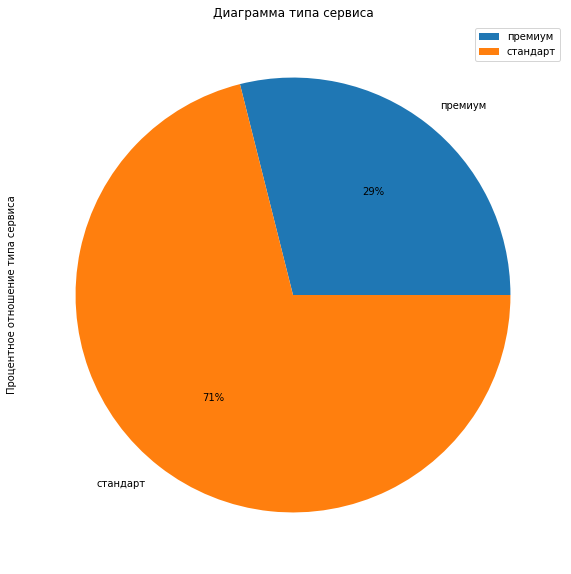

In [31]:
(
market_file
    .pivot_table(index='тип_сервиса',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), 
              label='Процентное отношение типа сервиса')
)
plt.title('Диаграмма типа сервиса')
plt.show()

По графику видно, что большая часть сервиса (71%) составляет стандартный тип, остальная часть премиум (29%).

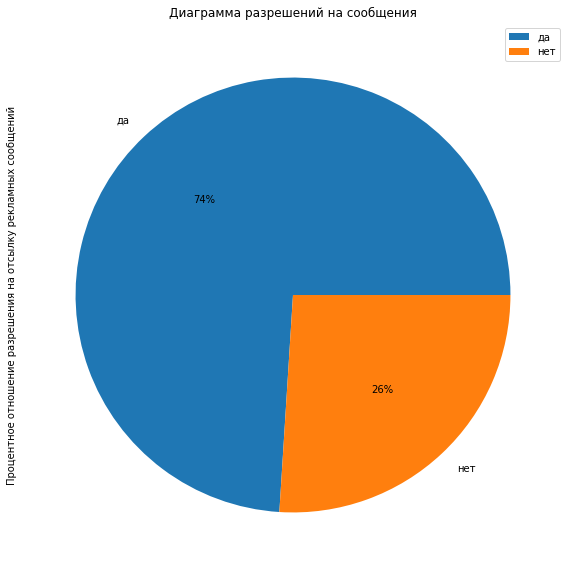

In [32]:
(
market_file
    .pivot_table(index='разрешить_сообщать',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10), 
              label='Процентное отношение разрешения на отсылку рекламных сообщений')
)
plt.title('Диаграмма разрешений на сообщения')
plt.show()

На графике видно, что большинство пользователей (74%) дали свое разрешение на получение сообщений, в то время как 26% отказались от получения таких сообщений.

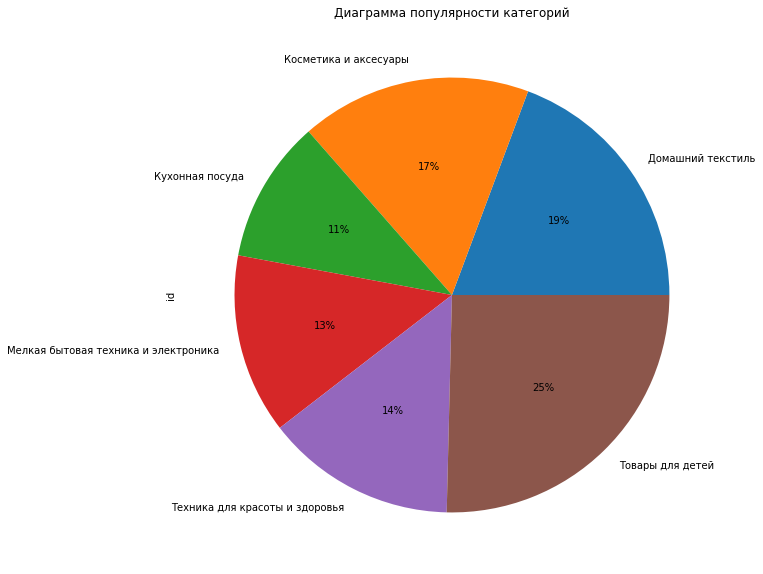

In [33]:
(
market_file
    .pivot_table(index='популярная_категория',values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,10))              
)
plt.title('Диаграмма популярности категорий')
plt.legend().remove()
plt.show()

Согласно диаграмме, самой популярной категорией являются товары для детей (25%), за ней следует домашний текстиль (19%). Также заметный интерес вызывает косметика и аксессуары (17%). Менее популярны техника для красоты и здоровья (14%), мелкая бытовая техника и электроника (13%) и кухонная посуда (11%).

**Анализ числовых значений `market_file`:**

In [34]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,4.253769,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,1.014814,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.900000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,3.700000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,4.200000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,4.900000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,6.600000,6.00000,10.000000,9.000000,20.000000


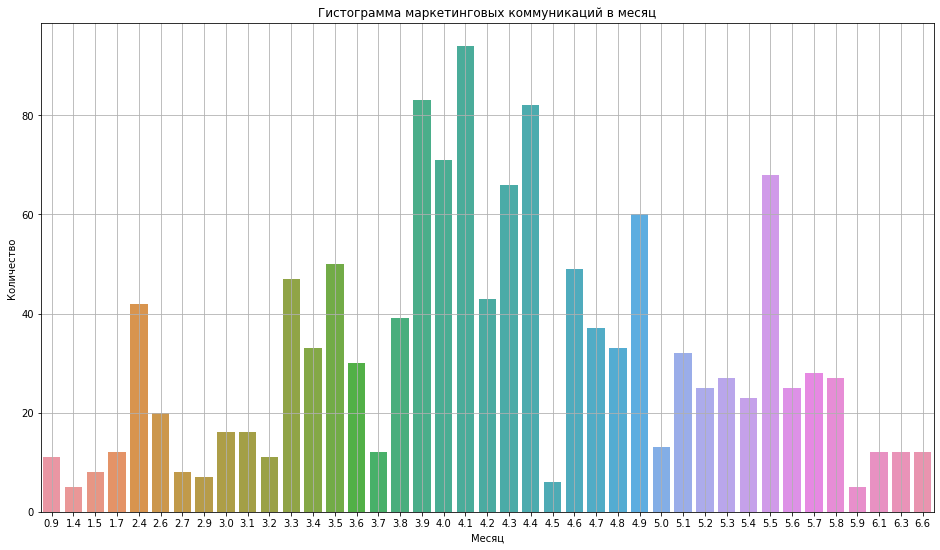

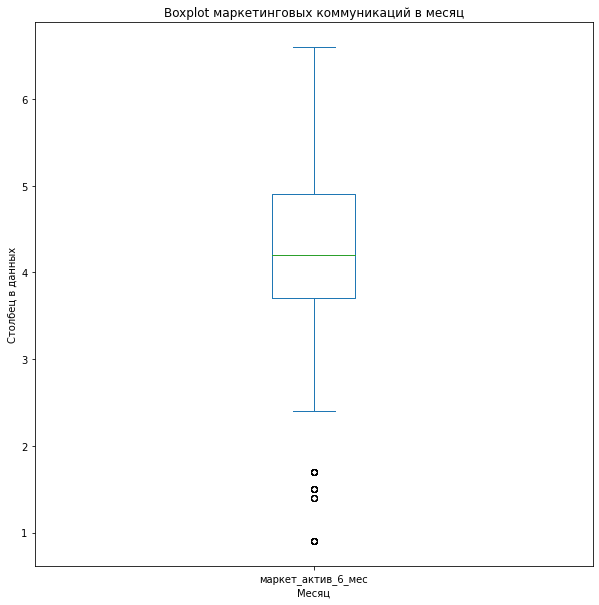

In [105]:
plt.figure(figsize=(16, 9))
sns.countplot(x='маркет_актив_6_мес', data=market_file)
plt.title('Гистограмма маркетинговых коммуникаций в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.grid(True)  # Если нужна сетка
plt.show()

(
    market_file['маркет_актив_6_мес']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Boxplot маркетинговых коммуникаций в месяц')
plt.xlabel('Месяц')
plt.ylabel('Столбец в данных')
plt.show()

1. Гистограмма: На графике видно, что наибольшее количество маркетинговых коммуникаций приходится на периоды 39–43 месяца, где количество достигает более 80 случаев. В других временных промежутках активность значительно ниже.
2. "Ящик с усами":  На графике видно, что большая часть значений маркетинговых коммуникаций сосредоточена в диапазоне от 3 до 5. При этом имеются выбросы ниже значения 2, что указывает на периоды с аномально низкой активностью. Верхняя граница (максимум) не содержит выбросов, что предполагает стабильность в высоких значениях.

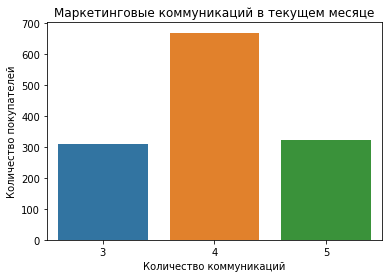

In [36]:
sns.countplot(x = 'маркет_актив_тек_мес', data =  market_file)
plt.title('Маркетинговые коммуникаций в текущем месяце')
plt.xlabel('Количество коммуникаций')
plt.ylabel('Количество покупателей')
plt.show()
plt.show()

Большинство покупателей (более 600) получили 4 маркетинговые коммуникации в текущем месяце. Меньшее количество покупателей получили 3 или 5 коммуникаций (около 300 и 400 соответственно).

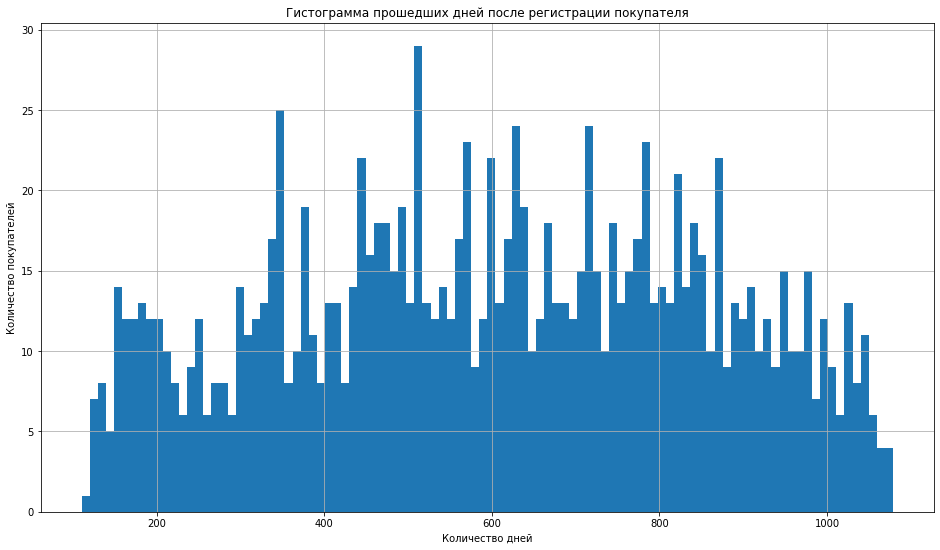

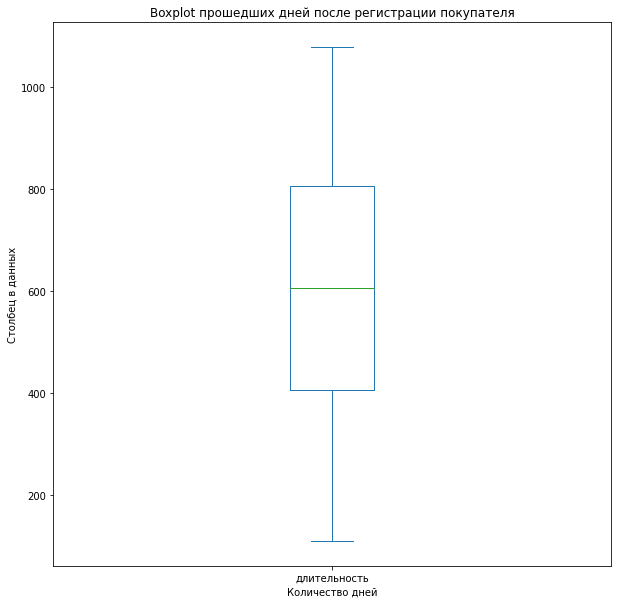

In [37]:
(
    market_file['длительность']
    .plot(kind='hist', bins=100, grid=True, figsize=(16, 9))
)
plt.title('Гистограмма прошедших дней после регистрации покупателя')
plt.xlabel('Количество дней')
plt.ylabel('Количество покупателей')
plt.show()

(
    market_file['длительность']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Boxplot прошедших дней после регистрации покупателя')
plt.xlabel('Количество дней')
plt.ylabel('Столбец в данных')
plt.show()

1. Гистограмма: На графике видно, что активность пользователей по времени относительно равномерна, однако наблюдаются некоторые локальные пики (особенно в районе 400 и 600 дней). Это может свидетельствовать о повышенной активности в определенные моменты, что, вероятно, связано с сезонностью, акциями или маркетинговыми кампаниями. 
2. "Ящик с усами":  На графике видно, что медианное количество дней, прошедших с момента регистрации покупателя, составляет около 600 дней. Межквартильный размах (от 400 до 800 дней) указывает, что основная часть значений лежит в этом диапазоне. Минимальное значение — около 100 дней, а максимальное — 1000 дней.

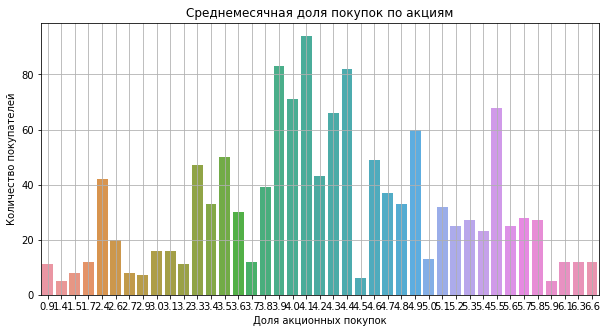

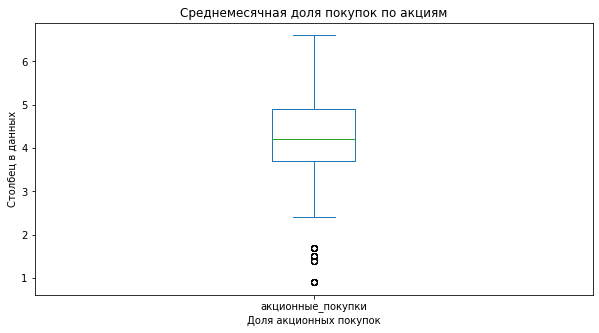

In [104]:
plt.figure(figsize=(10, 5))
sns.countplot(x='акционные_покупки', data=market_file)
plt.title('Среднемесячная доля покупок по акциям')
plt.xlabel('Доля акционных покупок')
plt.ylabel('Количество покупателей')
plt.grid(True)
plt.show()

(
    market_file['акционные_покупки']
    .plot(kind='box', figsize=(10, 5))
)
plt.title('Среднемесячная доля покупок по акциям')
plt.xlabel('Доля акционных покупок')
plt.ylabel('Столбец в данных')
plt.show()

- На первом графике видно, что большая часть покупателей имеет среднюю долю акционных покупок в диапазоне централизованных значений (от 40% до 70%). Наибольший пик приходится на диапазон около 50%-60%.
- На "ящике с усами" отображается медиана и межквартильный размах, что подтверждает концентрацию данных вокруг среднего значения (медиана близка к 50%).  
- Есть небольшое количество выбросов (покупатели с крайне низкой долей акционных покупок). 

Таким образом, большинство покупателей совершают акционные покупки в умеренной доле от общего числа.

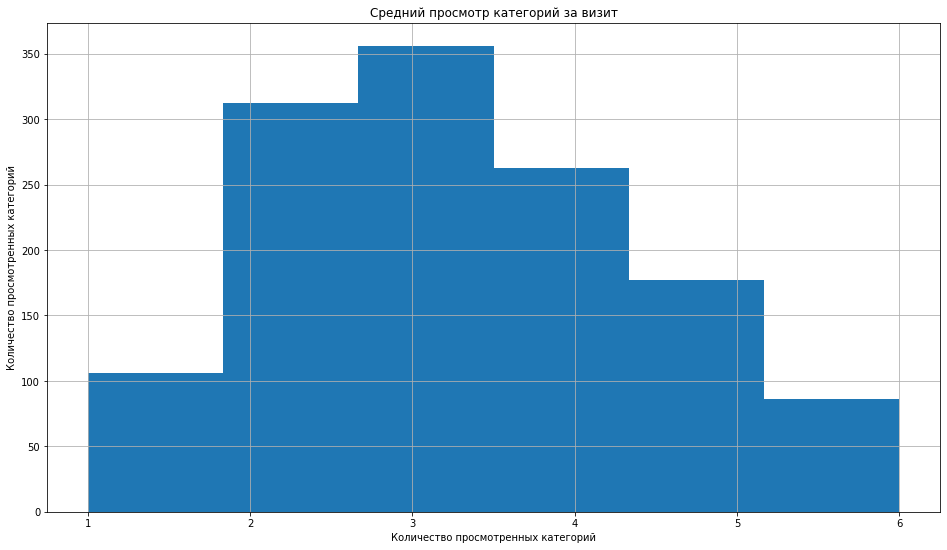

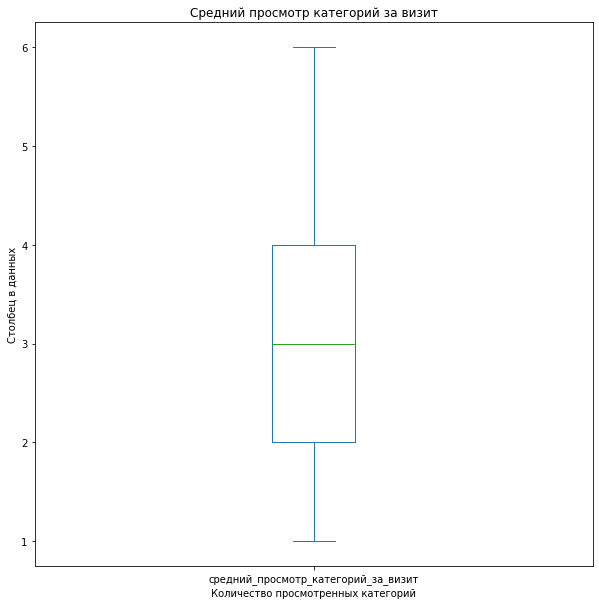

In [39]:
(
    market_file['средний_просмотр_категорий_за_визит']
    .plot(kind='hist', bins=6, grid=True, figsize=(16, 9))
)
plt.title('Средний просмотр категорий за визит')
plt.xlabel('Количество просмотренных категорий')
plt.ylabel('Количество просмотренных категорий')
plt.show()

(
    market_file['средний_просмотр_категорий_за_визит']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Средний просмотр категорий за визит')
plt.xlabel('Количество просмотренных категорий')
plt.ylabel('Столбец в данных')
plt.show()

1. Гистограмма: На графике видно, что наибольшее количество визитов приходится на просмотры 2-3 категорий, а затем количество снижается. Меньше всего визитов связано с просмотром 1 или 5 категорий. 
2. "Ящик с усами":  На графике видно, что медианное количество просмотренных категорий за визит составляет около 3. Межквартильный размах (от 2 до 4) указывает на то, что большинство визитов сопровождается просмотром этого количества категорий. Минимальное значение — 1 категория, а максимальное — 6.

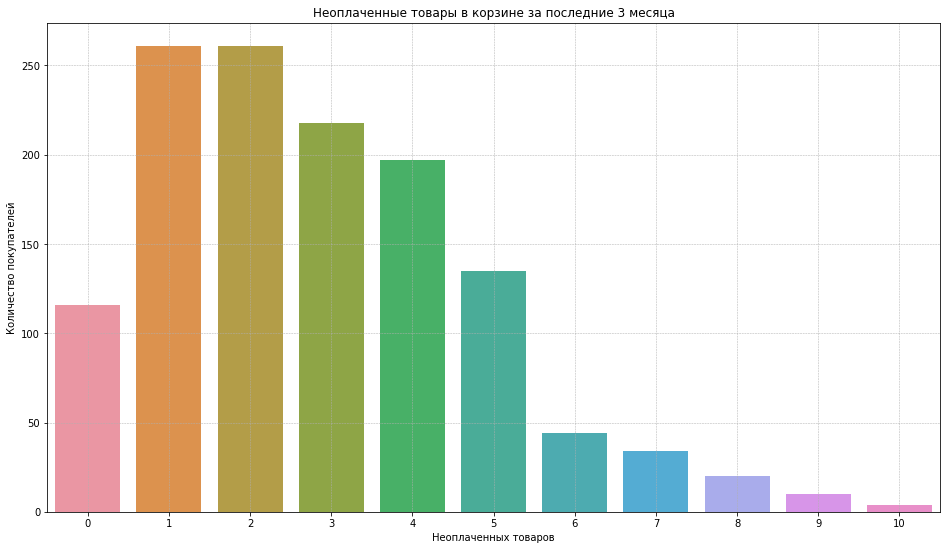

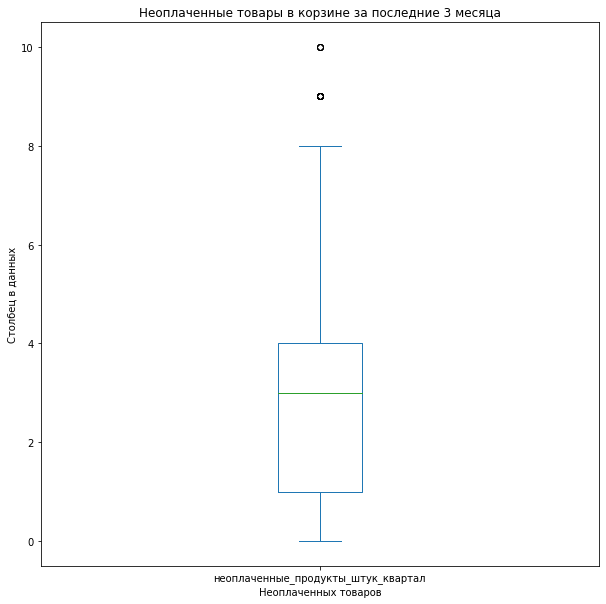

In [107]:
plt.figure(figsize=(16, 9))
sns.countplot(x='неоплаченные_продукты_штук_квартал', data=market_file)

plt.title('Неоплаченные товары в корзине за последние 3 месяца')
plt.xlabel('Неоплаченных товаров')
plt.ylabel('Количество покупателей')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # если нужен грид
plt.show()

(
    market_file['неоплаченные_продукты_штук_квартал']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Неоплаченные товары в корзине за последние 3 месяца')
plt.xlabel('Неоплаченных товаров')
plt.ylabel('Столбец в данных')
plt.show()

1. Гистограмма: На графике видно, что наибольшее количество пользователей оставляют в корзине 1 или 2 неоплаченных товара (более 250 человек). С увеличением количества неоплаченных товаров число пользователей постепенно снижается, и при 8-10 товарах в корзине остаётся минимальное количество пользователей. 
2. "Ящик с усами":  На графике видно, что медиана количества неоплаченных товаров за три месяца составляет примерно 2-3 единицы. Большинство данных находится в диапазоне от 1 до 6 товаров. Выбросы наблюдаются на уровнях около 8 и 10 товаров.  

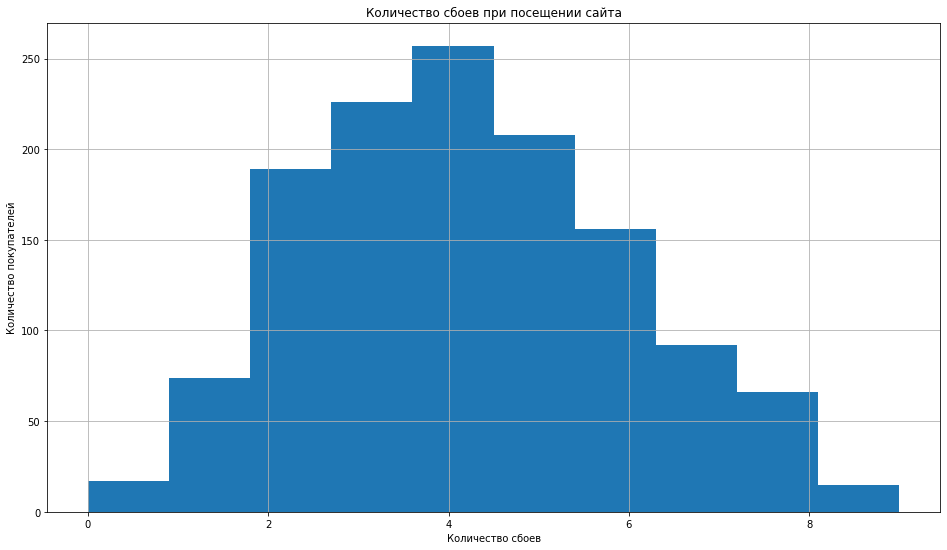

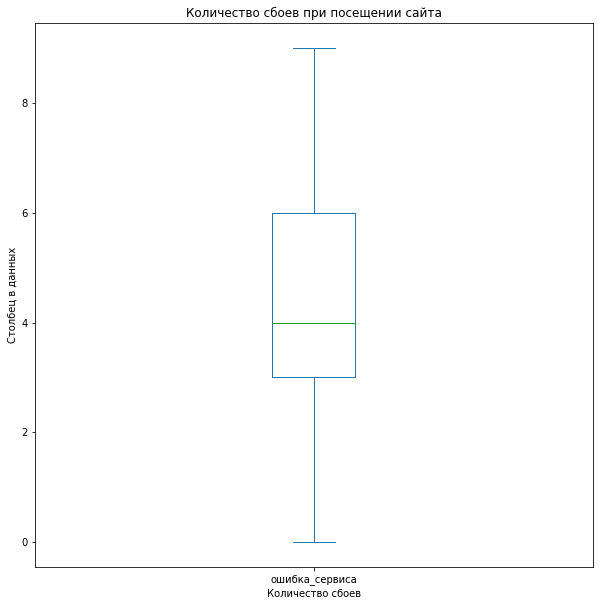

In [41]:
(
    market_file['ошибка_сервиса']
    .plot(kind='hist', bins=10, grid=True, figsize=(16, 9))
)
plt.title('Количество сбоев при посещении сайта')
plt.xlabel('Количество сбоев')
plt.ylabel('Количество покупателей')
plt.show()

(
    market_file['ошибка_сервиса']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Количество сбоев при посещении сайта')
plt.xlabel('Количество сбоев')
plt.ylabel('Столбец в данных')
plt.show()

1. Гистограмма: Большинство посещений сайта сопровождается от 3 до 5 сбоев. Более редкими являются случаи сбоев выше 6 или ниже 
2. "Ящик с усами":  медианное количество сбоев составляет 4, а межквартильный размах — от 3 до 6 сбоя. Минимальное значение — 0, а максимальное — 8.5 сбоев.  

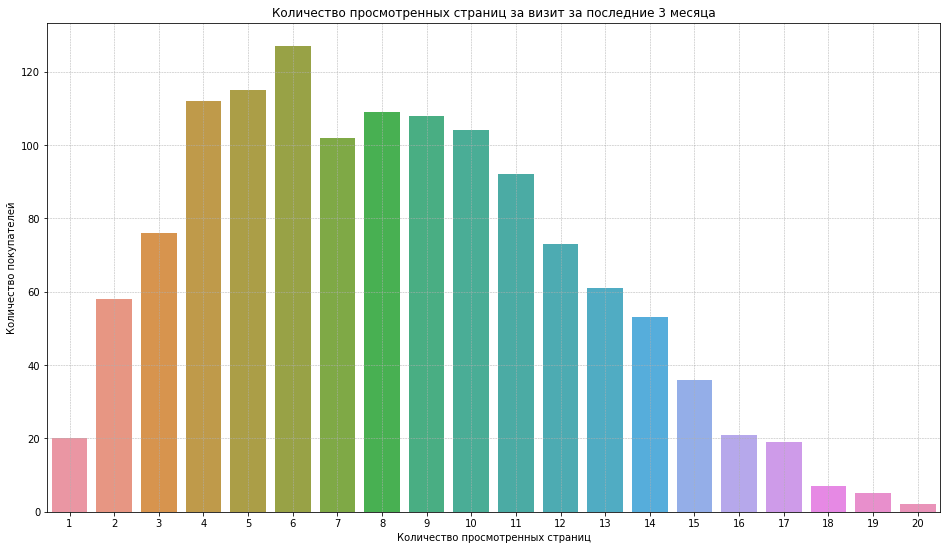

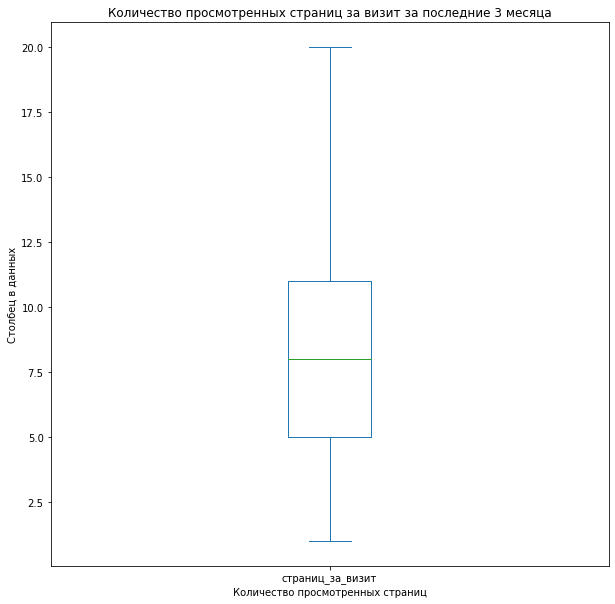

In [108]:
plt.figure(figsize=(16, 9))
sns.countplot(x='страниц_за_визит', data=market_file)

plt.title('Количество просмотренных страниц за визит за последние 3 месяца')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество покупателей')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # если нужен грид
plt.show()

(
    market_file['страниц_за_визит']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Количество просмотренных страниц за визит за последние 3 месяца')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Столбец в данных')
plt.show()

1. Гистограмма: Большинство пользователей просматривают от 5 до 11 страниц за один визит. Наибольший пик приходится на 6 страниц.  
2. "Ящик с усами":  
   - Медианное значение близко к 7.5 страницам.  
   - Основная часть данных (межквартильный размах) охватывает примерно от 5 до 11 страниц.   

Таким образом, среднее количество просмотренных страниц за визит сосредоточено в диапазоне 5-11 страниц.

**Анализ строковых значений `market_money`:**

Оставим в таблице только клиентов которые активны все три месяца:

In [43]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [44]:
market_money = market_money[market_money.id.isin(market_money.query('выручка==0')['id'].unique())==False] 
market_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   период   3891 non-null   object 
 2   выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB


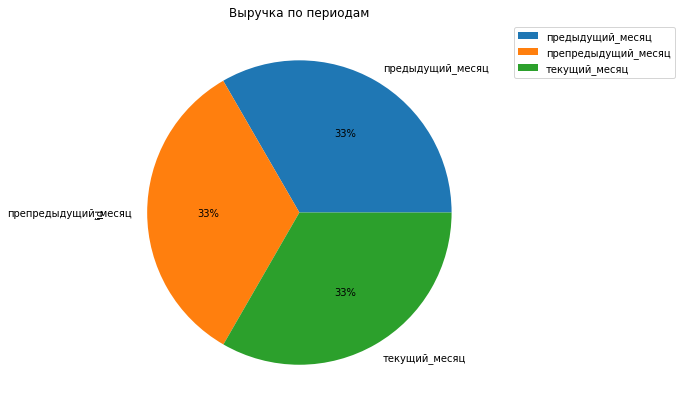

In [100]:
(
market_money
    .pivot_table(index='период', values='id', aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10, 7))
)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.title('Выручка по периодам')
plt.show()

Выручка по периодам распределена равномерно: на каждый период (текущий месяц, предыдущий месяц и предпредыдущий месяц) приходится 33%. Это говорит о стабильности выручки во времени без значительных изменений.

**Анализ числовых значений `market_money`:**

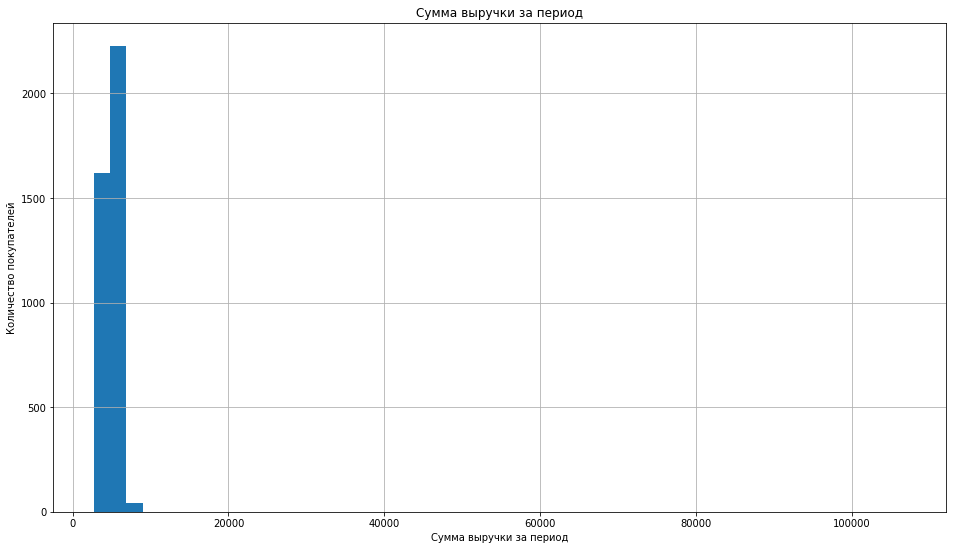

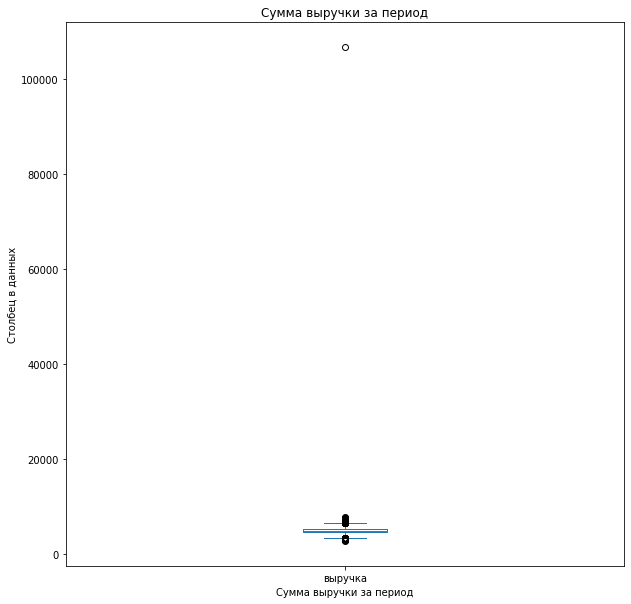

In [46]:
(
    market_money['выручка']
    .plot(kind='hist', bins=50, grid=True, figsize=(16, 9))
)
plt.title('Сумма выручки за период')
plt.xlabel('Сумма выручки за период')
plt.ylabel('Количество покупателей')
plt.show()

(
    market_money['выручка']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Сумма выручки за период')
plt.xlabel('Сумма выручки за период')
plt.ylabel('Столбец в данных')
plt.show()

In [47]:
market_money.sort_values(by='выручка', ascending=False).head()

,id,период,выручка
98,215380,текущий_месяц,106862.2
435,215493,текущий_месяц,7799.4
262,215435,текущий_месяц,7605.3
1481,215841,текущий_месяц,7557.0
2388,216144,текущий_месяц,7547.8


На графике видим аномально большой выброс. Это могла быть ошибка ввода данных. Удалим эту строку и проверим снова:

In [48]:
market_money = market_money.drop(index=95)
market_money = market_money.reset_index(drop=True)
market_money['выручка'].describe()

count      3890.000000
mean       5033.883111
std        1768.668968
min        2758.700000
25%        4592.250000
50%        4959.050000
75%        5363.300000
max      106862.200000
Name: выручка, dtype: float64

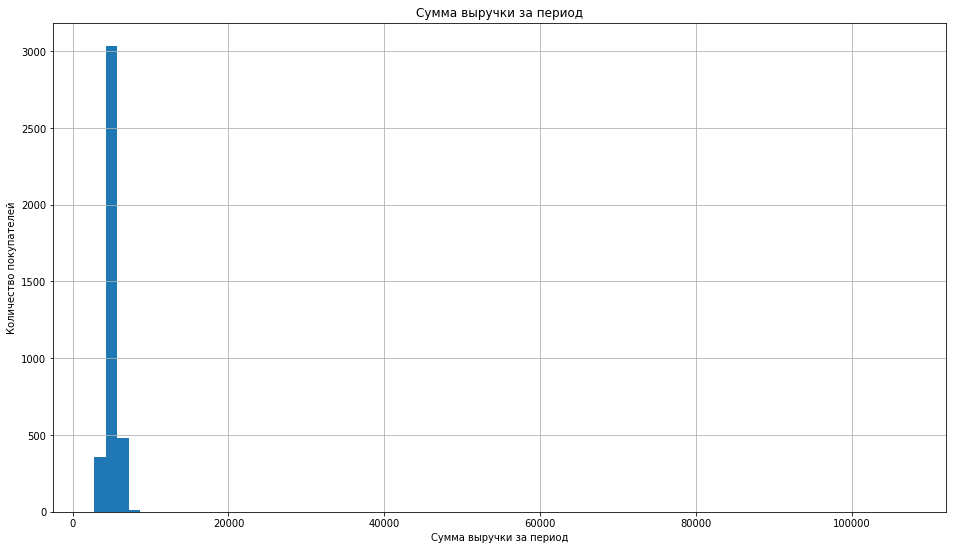

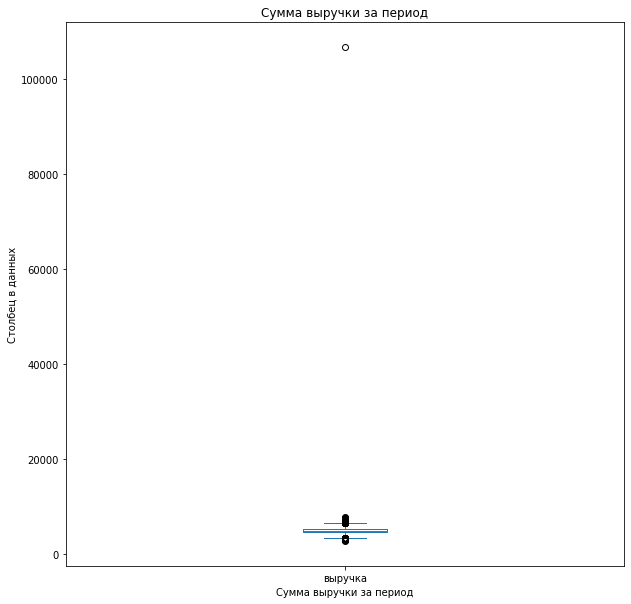

In [49]:
(
    market_money['выручка']
    .plot(kind='hist', bins=70, grid=True, figsize=(16, 9))
)
plt.title('Сумма выручки за период')
plt.xlabel('Сумма выручки за период')
plt.ylabel('Количество покупателей')
plt.show()

(
    market_money['выручка']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Сумма выручки за период')
plt.xlabel('Сумма выручки за период')
plt.ylabel('Столбец в данных')
plt.show()

In [50]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


**Анализ строковых значений `market_time`:**

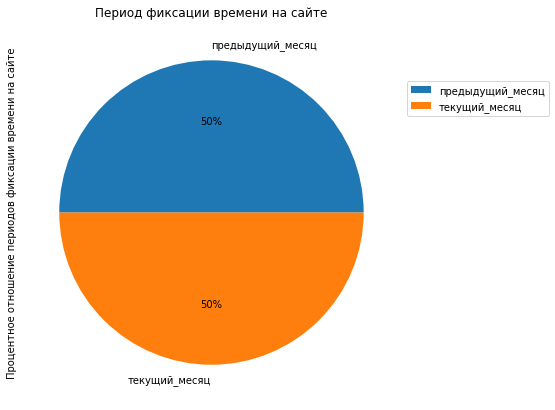

In [51]:
(
market_time
    .pivot_table(index='период', values='id',aggfunc='count')
    .plot.pie(y='id', autopct='%1.0f%%', figsize=(10,7), 
              label='Процентное отношение периодов фиксации времени на сайте')
)
plt.title('Период фиксации времени на сайте')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.show()

**Анализ числовых значений `market_time`:**

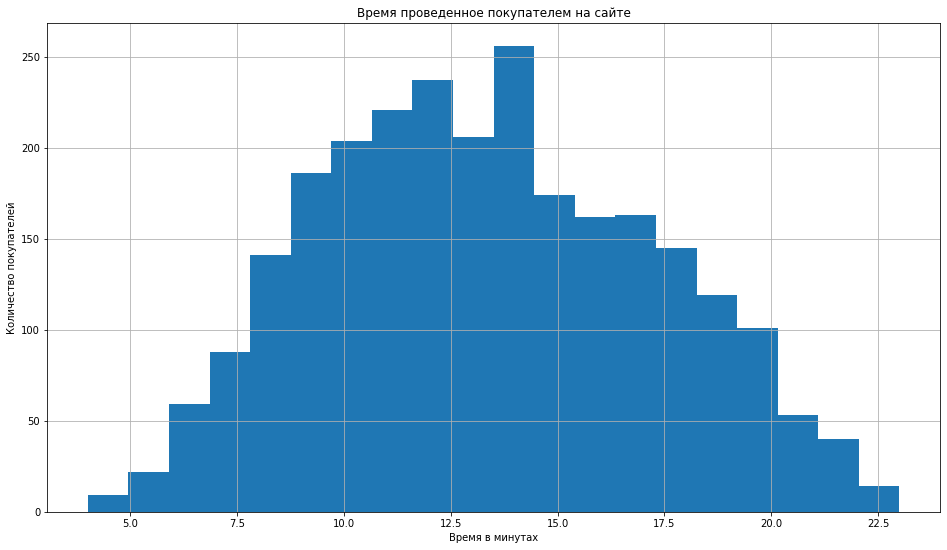

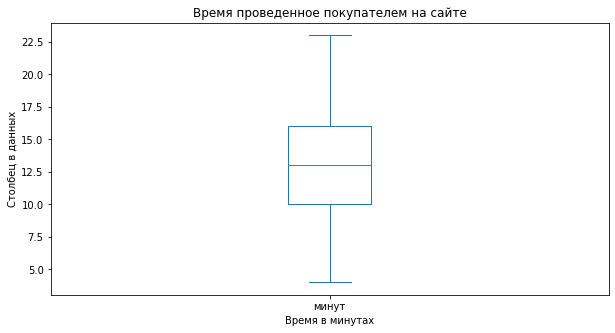

In [52]:
(
    market_time['минут']
    .plot(kind='hist', bins=20, grid=True, figsize=(16, 9))
)
plt.title('Время проведенное покупателем на сайте')
plt.xlabel('Время в минутах')
plt.ylabel('Количество покупателей')
plt.show()

(
    market_time['минут']
    .plot(kind='box', figsize=(10, 5))
)
plt.title('Время проведенное покупателем на сайте')
plt.xlabel('Время в минутах')
plt.ylabel('Столбец в данных')
plt.show()

1. Гистограмма: На графике видно, что распределение времени, проведенного покупателями на сайте, имеет симметричную форму, близкую к нормальной. Наибольшее количество пользователей находится в диапазоне около 12–15 минут, что является самым популярным интервалом времени. Большинство покупателей проводят на сайте от 10 до 20 минут.
2. "Ящик с усами":  На графике видно, что медианное время, проведённое покупателями на сайте, составляет около 12,5 минут. Большинство данных (межквартильный размах) лежит в пределах около 10–15 минут. Минимальное время составляет примерно 5 минут, а максимальное — 22,5 минут. Выбросов не наблюдается.

**Анализ числовых значений `money`:**

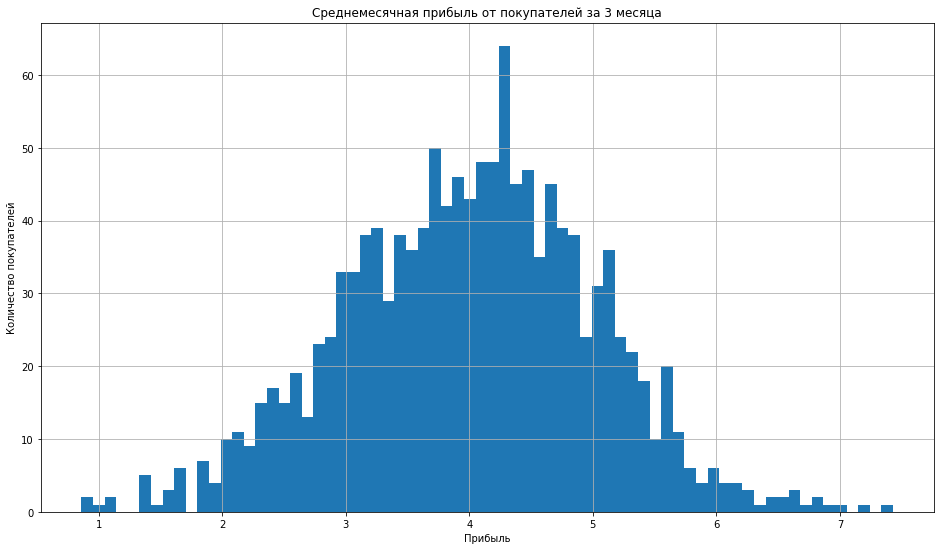

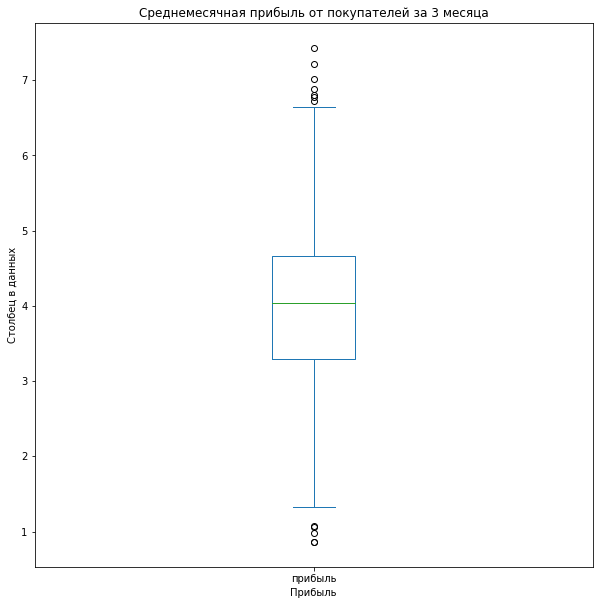

In [53]:
(
    money['прибыль']
    .plot(kind='hist', bins=70, grid=True, figsize=(16, 9))
)
plt.title('Среднемесячная прибыль от покупателей за 3 месяца')
plt.xlabel('Прибыль')
plt.ylabel('Количество покупателей')
plt.show()

(
    money['прибыль']
    .plot(kind='box', figsize=(10, 10))
)
plt.title('Среднемесячная прибыль от покупателей за 3 месяца')
plt.xlabel('Прибыль')
plt.ylabel('Столбец в данных')
plt.show()

1. Гистограмма: На графике видно, что близка к нормальному распределению с симметричным «колоколом». Основная масса прибыли сосредоточена в диапазоне от 3 до 5 единиц, наибольшее количество покупателей приносит примерно 4 единицы прибыли. Крайние значения (почти от 1 до 7) встречаются редко.
2. "Ящик с усами":  На графике видно, что распределение средней месячной прибыли от покупателей за 3 месяца. Основная часть значений сосредоточена в пределах от 2 до 6 единиц. Медиана прибыли составляет около 4 единиц. Присутствуют выбросы как в верхнем (свыше 6 единиц), так и в нижнем (около 1 единицы) диапазоне, что указывает на аномальные значения в данных.

***Вывод***

Большинство данных имеют нормальное распределение. Обнаружены выбросы. Они могут быть связаны с сезонностью продаж, особенностью активности отдельных покупателей, также не исключены ошибки ввода данных. Аномально большой выброс был удален.

Исходя из результатов исследования данных видим, что большая доля покупок состоит из товаров для детей (25%), 74% клиентов согласились на рекламную рассылку, примерно столько же имеют стандартный тип сервиса, и 62% сохранили свою покупательную активность. 

Активные пользователи за последние 3 месяца отобраны в таблице market_money (1297 покупателей).

## Шаг 4. Объединение таблиц

**4.1 Объединим таблицы `market_file.csv`, `market_money.csv`, `market_time.csv`. Данные о прибыли из файла `money.csv` при моделировании нам не понадобятся.**

**Подготовка таблиц перед объединением:**

Подготовка `market_file`:

In [54]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

**Подготовка `market_time`:**

In [55]:
print(market_time.info(), '\n')

df_1 = market_time[market_time['период']=='предыдущий_месяц'].copy()
df_1.rename(columns={'минут':'минут_предыдущего_месяца'},inplace=True)
df_1.drop('период', axis= 1 , inplace= True )

df_2 = market_time[market_time['период']=='текущий_месяц'].copy()
df_2.rename(columns={'минут':'минут_текущего_месяца'},inplace=True)
df_2.drop('период', axis= 1 , inplace= True )

df_market_time = pd.merge(df_1, df_2, on='id', sort=True)

print(df_market_time.info())
df_market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   id                        1300 non-null   int64
 1   минут_предыдущего_месяца  1300 non-null   int64
 2   минут_текущего_месяца     1300 non-null   int64
dtypes: int64(3)
memory usage: 40.6 KB
None


,id,минут_предыдущего_месяца,минут_текущего_месяца
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


Подготовка `market_money`:

In [56]:
market_money.head()

,id,период,выручка
0,215349,препредыдущий_месяц,4472.0
1,215349,текущий_месяц,4971.6
2,215349,предыдущий_месяц,5216.0
3,215350,препредыдущий_месяц,4826.0
4,215350,текущий_месяц,5058.4


In [57]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [58]:
df_1 = market_money[market_money['период']=='текущий_месяц'].copy()
df_1.rename(columns={'выручка':'выручка_предыдущего_месяца'},inplace=True)
df_1.drop('период', axis= 1 , inplace= True )
df_2 = market_money[market_money['период']=='предыдущий_месяц'].copy()
df_2.rename(columns={'выручка':'выручка_текущего_месяца'},inplace=True)
df_2.drop('период', axis= 1 , inplace= True )
df_3 = market_money[market_money['период']=='препредыдущий_месяц'].copy()
df_3.rename(columns={'выручка':'выручка_препредыдущего_месяца'},inplace=True)
df_3.drop('период', axis= 1 , inplace= True )
df_market_money = pd.merge(df_1, df_2, on='id', sort=True)
df_market_money = pd.merge(df_3, df_market_money, on='id', sort=True)
print(df_market_money.info())
df_market_money.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             1296 non-null   int64  
 1   выручка_препредыдущего_месяца  1296 non-null   float64
 2   выручка_предыдущего_месяца     1296 non-null   float64
 3   выручка_текущего_месяца        1296 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 50.6 KB
None


,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца
0,215349,4472.0,4971.6,5216.0
1,215350,4826.0,5058.4,5457.5
2,215351,4793.0,6610.4,6158.0
3,215352,4594.0,5872.5,5807.5
4,215353,5124.0,5388.5,4738.5


**Объединим таблицы:**

In [59]:
df = pd.merge(df_market_money, pd.merge(df_market_time, market_file, on='id', sort=True), on='id', sort=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   выручка_препредыдущего_месяца        1296 non-null   float64
 2   выручка_предыдущего_месяца           1296 non-null   float64
 3   выручка_текущего_месяца              1296 non-null   float64
 4   минут_предыдущего_месяца             1296 non-null   int64  
 5   минут_текущего_месяца                1296 non-null   int64  
 6   покупательская_активность            1296 non-null   object 
 7   тип_сервиса                          1296 non-null   object 
 8   разрешить_сообщать                   1296 non-null   object 
 9   маркет_актив_6_мес                   1296 non-null   float64
 10  маркет_актив_тек_мес                 1296 non-null   int64  
 11  длительность                  

,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,минут_предыдущего_месяца,минут_текущего_месяца,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215349,4472.0,4971.6,5216.0,12,10,Снизилась,премиум,да,4.4,4,819,4.4,Товары для детей,4,4,2,5
1,215350,4826.0,5058.4,5457.5,8,13,Снизилась,стандарт,нет,4.9,3,539,4.9,Домашний текстиль,5,2,1,5
2,215351,4793.0,6610.4,6158.0,11,13,Снизилась,стандарт,да,3.2,5,896,3.2,Товары для детей,5,0,6,4
3,215352,4594.0,5872.5,5807.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,5.1,Товары для детей,3,2,3,2
4,215353,5124.0,5388.5,4738.5,10,10,Снизилась,стандарт,да,3.3,4,762,3.3,Домашний текстиль,4,1,1,4


***Вывод по объединению таблиц***

Данные успешно объедены, в `data` проведено преобразование данных:

Столбец `выручка` удален созданы новые столбцы:

- `выручка_предыдущего_месяца`

- `выручка_текущего_месяца`

Столбец `минут` удален созданы новые столбцы:

- `минут_предыдущего_месяца`

- `минут_текущего_месяца`

## Шаг 5. Корреляционный анализ

**5.1 Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.**

In [60]:
df = df.sort_values(by=['id']).set_index('id')

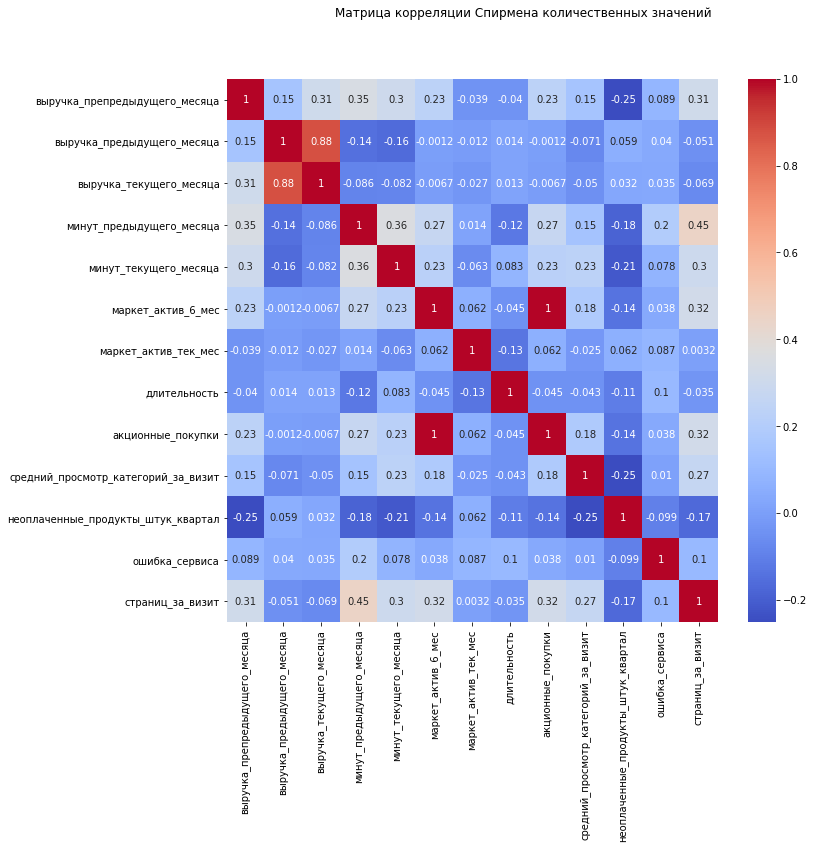

In [61]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции Спирмена количественных значений')
#sns.heatmap(df.drop('id', axis=1).corr(method="spearman", numeric_only=True), annot=True, cmap='coolwarm');
sns.heatmap(df.corr(method="spearman", numeric_only=True), annot=True, cmap='coolwarm');

Построим тепловую карту корреляции phi(k) для количественных данных распределение которых ненормальное с выбросами:

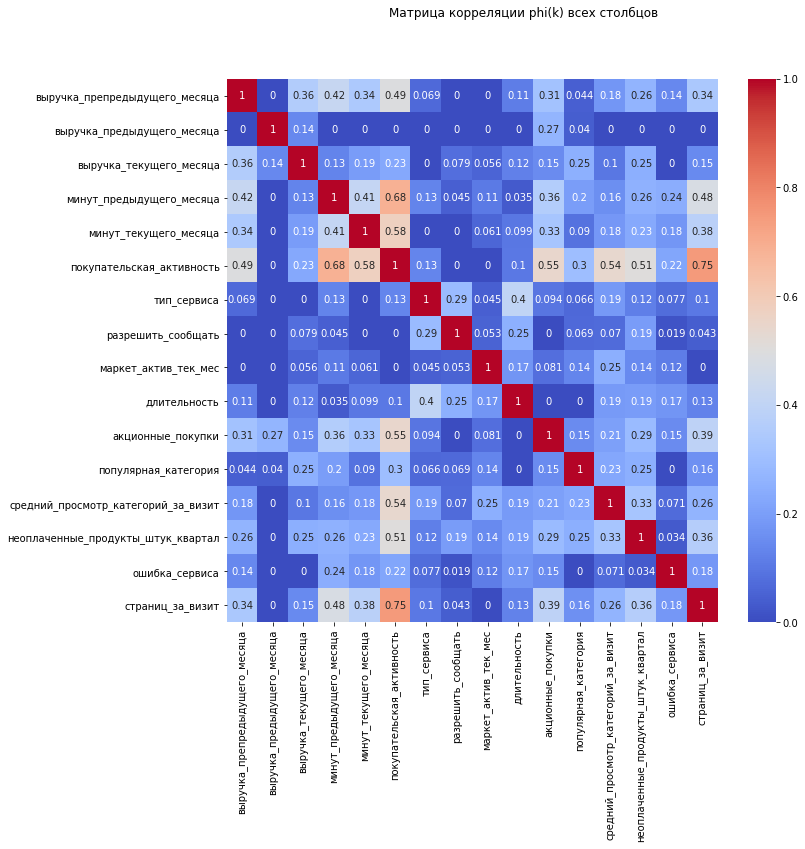

In [102]:
interval_cols = ['выручка_препредыдущего_месяца',
                 'выручка_предыдущего_месяца', 
                 'выручка_текущего_месяца',
                 'минут_предыдущего_месяца',
                 'минут_текущего_месяца',
                 'маркет_актив_тек_мес',
                 'длительность',
                 'акционные_покупки',
                 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал',
                 'ошибка_сервиса',
                 'страниц_за_визит'
                ]
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
#sns.heatmap(df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');
sns.heatmap(df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Максимальное значение корреляция Спирмена  = 0,87

Максимальное значение корреляция phi(k) = 0,75

Между столбцами `маркет_актив_6_мес` и  `акционные_покупки` прослеживается мультиколлениарность избавимся от одного из них:

In [63]:
df = df.drop(['маркет_актив_6_мес'], axis=1)

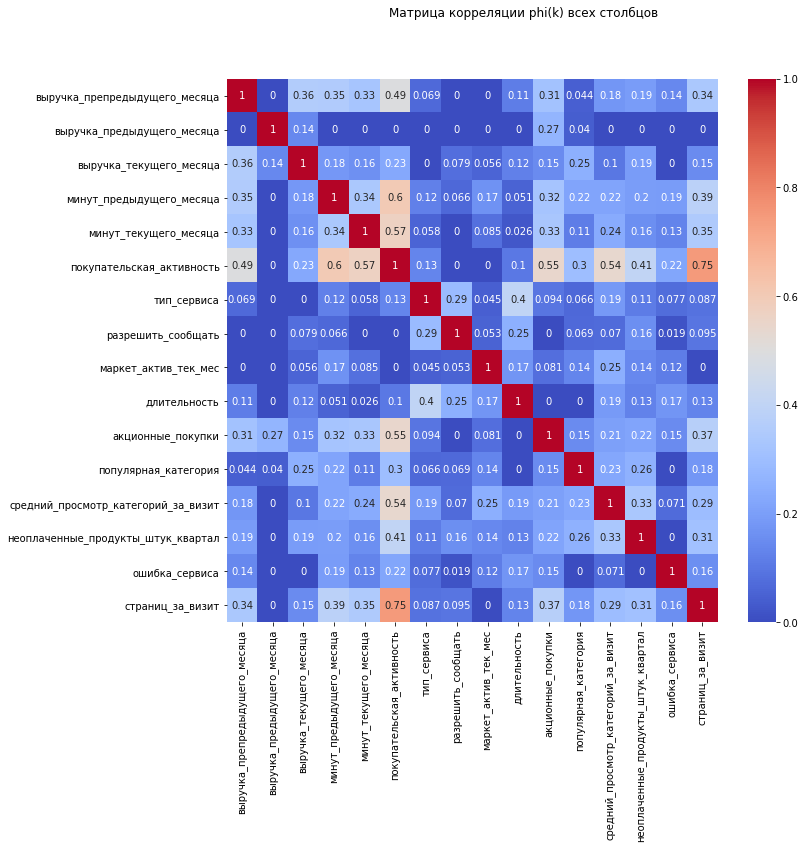

In [64]:
interval_cols = ['выручка_препредыдущего_месяца',
                 'выручка_предыдущего_месяца', 
                 'выручка_текущего_месяца',
                 'длительность',
                 'акционные_покупки'
                ]
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов')
sns.heatmap(df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

**Вывод по корреляционному анализу**

Между входными параметрами отсутствует связь выше 0,9 следовательно мультиколлинеарность отсутствует.

Максимальное значение корреляция Спирмена (непараметрическая мера оценивающая монотонность связи) corr(S) = 0,88 

Максимальное значение корреляция phi(k) (учитывает нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае бинарного нормального распределения входных данных) phi(k) = 0,84

## Шаг 6. Использование пайплайнов

**6.1 Во время подготовки данных используем `ColumnTransformer`. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков используем как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера:**

In [65]:
RANDOM_STATE = 42
X = df.drop(['покупательская_активность'], axis=1)
y = df['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify = y)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

le = LabelEncoder()
le.fit_transform(y_train.unique())
print ('Значениям', le.classes_, 'назначено соответственно', le.transform(le.classes_))
y_train = le.transform(y_train)
y_test = le.transform(y_test)

(972, 15)

(324, 15)

(972,)

(324,)

Значениям ['Прежний уровень' 'Снизилась'] назначено соответственно [0 1]


Кодирование целевого признака проведено корректно.

Создадим списки с названиями признаков:

In [66]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
df['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [67]:
num_columns = ['выручка_препредыдущего_месяца',       
               'выручка_предыдущего_месяца',          
               'выручка_текущего_месяца',             
               'минут_предыдущего_месяца',            
               'минут_текущего_месяца',               
               'маркет_актив_тек_мес',                
               'длительность',                        
               'акционные_покупки',                   
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',  
               'ошибка_сервиса',                      
               'страниц_за_визит']

Создадим пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование:

In [68]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Создадим пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование:

In [69]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['да', 'нет'],
                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим общий пайплайн для подготовки данных:

In [70]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**6.2 Обучим четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и  `SVC()`. Для каждой из них подберем как минимум один гиперпараметр. Выберем подходящую для задачи метрику, аргументируем свой выбор. Используем эту метрику при подборе гиперпараметров:**

**KNeighborsClassifier()**

In [71]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        
    }
]

knc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
    
)

knc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', knc.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', knc.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [72]:
choosing_model_separately = pd.DataFrame(knc.cv_results_).sort_values(
    by=['rank_test_score']
).head(1)
choosing_model_separately[['rank_test_score', 'param_models', 'mean_test_score', 'params']]

,rank_test_score,param_models,mean_test_score,params
5,1,KNeighborsClassifier(),0.894008,"{'preprocessor__num': RobustScaler(), 'models__n_neighbors': 14, 'models': KNeighborsClassifier()}"


**DecisionTreeClassifier()**

In [73]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 500),
        'models__max_features': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
     }
]

dtc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

dtc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', dtc.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', dtc.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [74]:
choosing_model_1 = pd.DataFrame(dtc.cv_results_).sort_values(by=['rank_test_score']).head(1)
choosing_model_separately = pd.concat([choosing_model_separately, choosing_model_1], ignore_index= True )
choosing_model_separately[['rank_test_score', 'param_models', 'mean_test_score', 'params']]

,rank_test_score,param_models,mean_test_score,params
0,1,KNeighborsClassifier(),0.894008,"{'preprocessor__num': RobustScaler(), 'models__n_neighbors': 14, 'models': KNeighborsClassifier()}"
1,1,DecisionTreeClassifier(random_state=42),0.801395,"{'preprocessor__num': StandardScaler(), 'models__max_features': 7, 'models__max_depth': 12, 'models': DecisionTreeClassifier(random_state=42)}"


**LogisticRegression()**

In [75]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',penalty='l1'))
])

param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',penalty='l1')],
        'models__C': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        
    }
]

lr = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', lr.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', lr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [76]:
choosing_model_1 = pd.DataFrame(lr.cv_results_).sort_values(by=['rank_test_score']).head(1)
choosing_model_separately = pd.concat([choosing_model_separately, choosing_model_1], ignore_index= True )
choosing_model_separately[['rank_test_score', 'param_models', 'mean_test_score', 'params']]

,rank_test_score,param_models,mean_test_score,params
0,1,KNeighborsClassifier(),0.894008,"{'preprocessor__num': RobustScaler(), 'models__n_neighbors': 14, 'models': KNeighborsClassifier()}"
1,1,DecisionTreeClassifier(random_state=42),0.801395,"{'preprocessor__num': StandardScaler(), 'models__max_features': 7, 'models__max_depth': 12, 'models': DecisionTreeClassifier(random_state=42)}"
2,1,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.889118,"{'preprocessor__num': StandardScaler(), 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"


**SVC()**

In [77]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, probability=True))
])

In [78]:
param_grid = [
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__degree': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        
    }
]

svc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

svc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', svc.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс - валидации:', svc.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [79]:
choosing_model_1 = pd.DataFrame(svc.cv_results_).sort_values(by=['rank_test_score']).head(1)
choosing_model_separately = pd.concat([choosing_model_separately, choosing_model_1], ignore_index= True )
choosing_model_separately[['rank_test_score', 'param_models', 'mean_test_score', 'params']].sort_values(by=['mean_test_score'], ascending = False)

,rank_test_score,param_models,mean_test_score,params
3,1,"SVC(probability=True, random_state=42)",0.900337,"{'preprocessor__num': RobustScaler(), 'models__kernel': 'rbf', 'models__degree': 3, 'models': SVC(probability=True, random_state=42)}"
0,1,KNeighborsClassifier(),0.894008,"{'preprocessor__num': RobustScaler(), 'models__n_neighbors': 14, 'models': KNeighborsClassifier()}"
2,1,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.889118,"{'preprocessor__num': StandardScaler(), 'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
1,1,DecisionTreeClassifier(random_state=42),0.801395,"{'preprocessor__num': StandardScaler(), 'models__max_features': 7, 'models__max_depth': 12, 'models': DecisionTreeClassifier(random_state=42)}"


**6.3 Выберем лучшую модель, используя заданную метрику:**

In [80]:
choosing_model_separately = choosing_model_separately.sort_values(by=['mean_test_score'], ascending = False).head(1)
choosing_model_separately[[
    'param_models',
    'params',
    'mean_test_score'
]]

,param_models,params,mean_test_score
3,"SVC(probability=True, random_state=42)","{'preprocessor__num': RobustScaler(), 'models__kernel': 'rbf', 'models__degree': 3, 'models': SVC(probability=True, random_state=42)}",0.900337


In [109]:
print('Площадь ROC-кривой на кросс-валидации:', knc.best_score_)
roc_auc_knc_test = roc_auc_score(y_test, knc.predict_proba(X_test)[:, 1])
print('Площадь ROC-кривой на тестовой выборке:', roc_auc_knc_test)
roc_auc_knc_km = (roc_auc_knc_test - svc.best_score_) / knc.best_score_*100
print(f'Потеря качества на тестовой выборке  = {roc_auc_knc_km:.2f} %')

Площадь ROC-кривой на кросс-валидации: 0.8940076588985679
Площадь ROC-кривой на тестовой выборке: 0.9255147029082231
Потеря качества на тестовой выборке  = 2.82 %


**Вывод по использованию пейплайнов и выбора лучшей модели**

Лучшая модель: SVC()

Параметры модели удовлетворительные:
- Площадь ROC-кривой на кросс-валидации: 0.894
- Площадь ROC-кривой на тестовой выборке: 0.925
- Прирост качества на тестовой выборке  = 2.82 %

## Шаг 7. Анализ важности признаков

**7.1 Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP:**

In [82]:
pipe_final = Pipeline([('preprocessor', data_preprocessor),('models', SVC(degree=3, probability=True, random_state=RANDOM_STATE))]).fit(X_train, y_train)

best_model = svc.best_estimator_

X_train_trans = pd.DataFrame(data_preprocessor.transform(X_train), columns=data_preprocessor.get_feature_names_out())
X_test_trans = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())
explainer = shap.KernelExplainer(best_model.named_steps['models'].predict, X_train_trans)
shap_values = explainer.shap_values(X_test_trans, nsamples=100)

Using 972 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/324 [00:00<?, ?it/s]

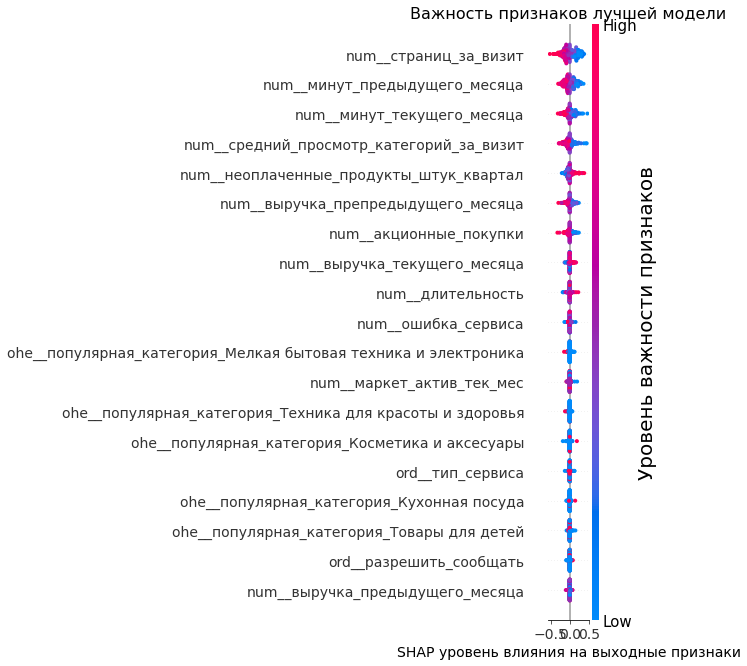

In [83]:
shap.initjs()
shap.summary_plot(shap_values, X_test_trans, show=False)

# Получение текущих объектов
fig, ax = plt.gcf(), plt.gca()

# Изменение основных параметров графика
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP уровень влияния на выходные признаки", fontsize=14)
ax.set_title('Важность признаков лучшей модели', fontsize=16)

# Получить цветовую панель
cb_ax = fig.axes[1] 

# Изменение параметров цветовой панели
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Уровень важности признаков", fontsize=20)

plt.show()

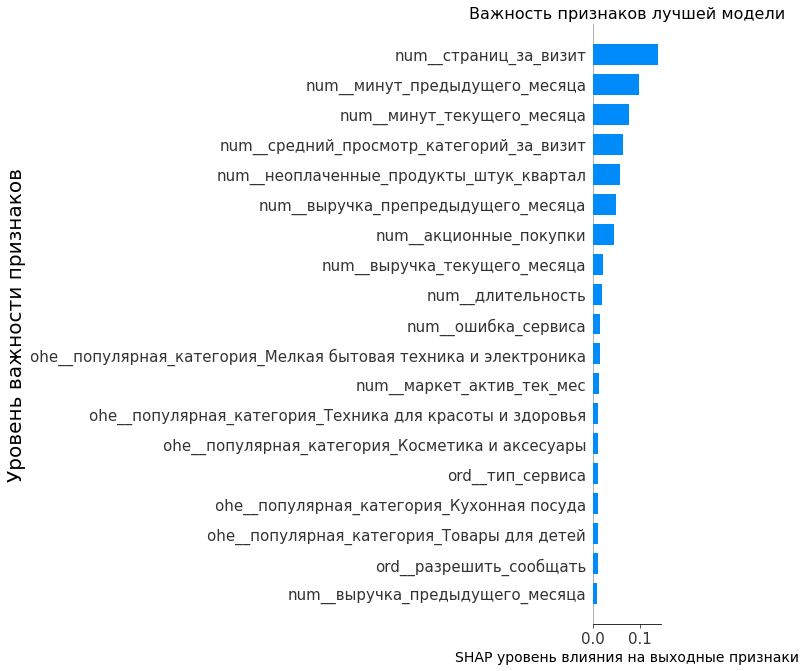

In [84]:
shap.initjs()
shap.summary_plot(shap_values, X_test_trans, plot_type='bar', show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP уровень влияния на выходные признаки", fontsize=14)
ax.set_title('Важность признаков лучшей модели', fontsize=16)
cb_ax = fig.axes[0] 
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("Уровень важности признаков", fontsize=20)
plt.show();

**7.2 Сделаем выводы о значимости признаков:**

Отобрана лучшая модель: `SVC()`

Наиболее важные признаки (по убывающей):
- 'страниц_за_визит'
- 'минут_предыдущего_месяца'
- 'минут_текущегого_месяца'
- 'средний_просмотр_категорий_за_визит'

Менее важные признаки :
- 'популярная_категория_Товары для детей'
- 'разрешить_сообщать'
- 'популярная_категория_Кухонная посуда'
- 'тип сервиса'

## Шаг 8. Сегментация покупателей

**8.1 Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей:**

In [85]:
med = money['прибыль'].median()
sko = np.std(money['прибыль'])
print("Медианное значение : ", med)
print("Стандартное отклонение : ", sko)
money['прибыль'].describe()

Медианное значение :  4.045
Стандартное отклонение :  1.0133321434255445


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

Функция расчета предсказаний с учетом изменяемого порога:

In [86]:
def custom_predict(X, threshold):
    probs = pipe_final.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

In [87]:
# предсказание на данных с выбранным порогом
predictions_precision = custom_predict(X, threshold=0.5)
X['predictions'] = predictions_precision
X['probs'] = pipe_final.predict_proba(X)[:,1]

In [88]:
money['категории_прибыли'] = money['прибыль'].apply(lambda x: 'мало' if x < (med - sko) 
                                                       else ('много' if x > (med + sko) 
                                                       else 'нормально'))

In [89]:
# Вернем индекс в таблицу для их объединения
X = X.reset_index()

In [90]:
X = pd.merge(X, money, on='id', sort=True)
X.head()

,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,минут_предыдущего_месяца,минут_текущего_месяца,тип_сервиса,разрешить_сообщать,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,predictions,probs,прибыль,категории_прибыли
0,215349,4472.0,4971.6,5216.0,12,10,премиум,да,4,819,4.4,Товары для детей,4,4,2,5,1,0.891874,4.16,нормально
1,215350,4826.0,5058.4,5457.5,8,13,стандарт,нет,3,539,4.9,Домашний текстиль,5,2,1,5,1,0.677761,3.13,нормально
2,215351,4793.0,6610.4,6158.0,11,13,стандарт,да,5,896,3.2,Товары для детей,5,0,6,4,1,0.605929,4.87,нормально
3,215352,4594.0,5872.5,5807.5,8,11,стандарт,нет,3,1064,5.1,Товары для детей,3,2,3,2,1,0.929905,4.21,нормально
4,215353,5124.0,5388.5,4738.5,10,10,стандарт,да,4,762,3.3,Домашний текстиль,4,1,1,4,1,0.888378,3.95,нормально


Построим диаграмму рассеяния вероятности "Снижения покупательской активности" и прибыли для визуализации границы разделения на группы покупательской активности:

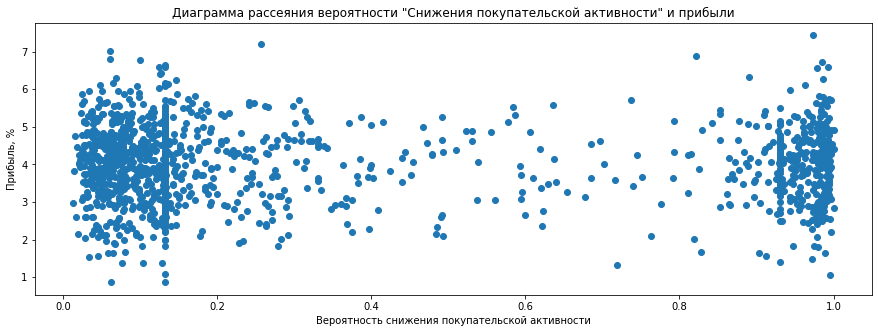

In [91]:
plt.figure(figsize=[15, 5])
plt.scatter(X.probs, X.прибыль);
plt.title('Диаграмма рассеяния вероятности "Снижения покупательской активности" и прибыли')
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль, %')
plt.show()

Введем котегориальный столбец в данные, для сравнения данных.
Определим границу разделения 0.79:

In [92]:
X['категория_снижения'] = X['probs'].apply(lambda x: 'Снизилась' if x > 0.79 else 'Прежний уровень')   

**8.2 Выберем группу покупателей и предложим, как увеличить её покупательскую активность:**

Выделим группу с малым доходом и высокой вероятностью снижения покупательской способности, для сравнения оставим группу с прежним уровнем активности. Она покажет целевой уровень, куда нужно стремиться и какие решения принимать в разрезе важных признаков, определенных на 7 шаге работы.

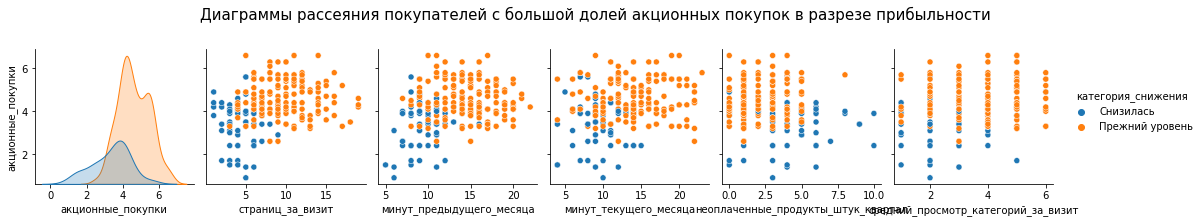

In [93]:
x=['акционные_покупки',
   'страниц_за_визит',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит'
  ]

y=['акционные_покупки'
  ]

g = sns.pairplot(X.query('категории_прибыли == "мало"'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=15)
plt.show()

**Выделим группу клиентов, количество покупок акционных товаров не превышают 3 штук:**

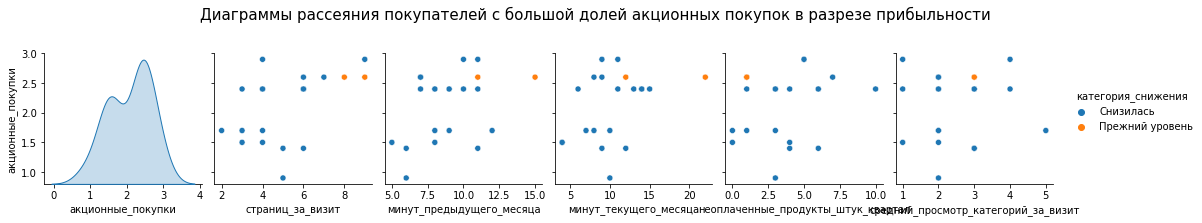

In [94]:
x=['акционные_покупки',
   'страниц_за_визит',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит'
  ]
y=['акционные_покупки'
  ]

g = sns.pairplot(X.query('категории_прибыли == "мало" & акционные_покупки < 3'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе прибыльности", y=1.2, fontsize=15)
plt.show()

**Группа клиентов, количество акционных товаров у которых не превышает 3 штук**

В этом сегменте наблюдается снижение покупательской активности. Активность клиентов особенно снижается у тех, у кого количество акционных покупок меньше 3, а у тех кто сделал 3 покупки уже могут попасть в среду активных пользователей. Возможно, это связано с уменьшением рекламных кампаний по акциям.

**Рекомендации:**

Выделить этих клиентов в отдельную рабочую группу и для увеличения их активности:
- Активнее предлагать акционные товары и проводить уведомления, рекламные кампании.
- Удерживать их внимание на страницах сайта: замечено, что при просмотре более 6 страниц покупательская активность остается на прежнем уровне.
- Увеличение числа просмотренных страниц приведет к увеличению времени, проведенного за визит. Если визит длится более 10 минут, вероятность сохранения покупательской активности повышается.

**Выделим группу клиентов, с высокой  прибыльностью и количества неоплаченных покупок в корзине больше 4**

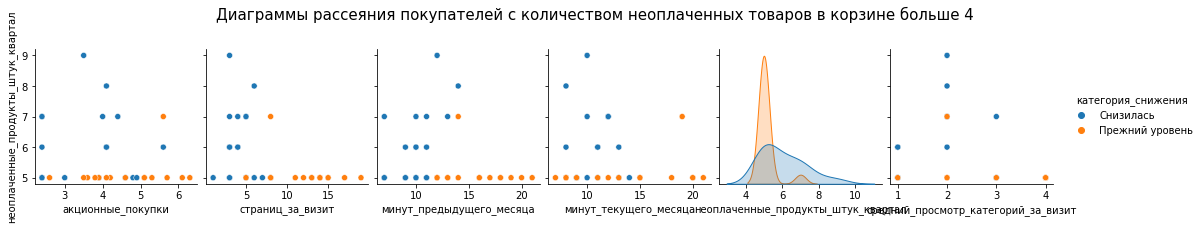

In [95]:
x=['акционные_покупки',
   'страниц_за_визит',
   'минут_предыдущего_месяца',
   'минут_текущего_месяца',
   'неоплаченные_продукты_штук_квартал',
   'средний_просмотр_категорий_за_визит'
  ]
y=['неоплаченные_продукты_штук_квартал'
  
  ]

g = sns.pairplot(X.query('категории_прибыли == "много" & неоплаченные_продукты_штук_квартал > 4'), hue='категория_снижения', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с количеством неоплаченных товаров в корзине больше 4", y=1.2, fontsize=15)
plt.show()

**Промежуточный итог**

В сегменте присутствует значительная доля снижения покупательской активности клиентов.

Предлагается выделить таких клиентов в отдельную рабочую группу и для учеличения их активности:
- при количестве неоплаченных продуктов в корзине болше 6, уведомлять об этом покупателя, что возможно приведет покупателя обратно на сайт, повысит остальные важные метрики и увеличит их покупательную активность.

В общем случае рекомендации такие же как и для предыдущей группы.

**8.3 Сделаем выводы о сегментах:**

**Группа клиентов, количество акционных товаров у которых не превышает 3 штуки**

В этом сегменте наблюдается снижение покупательской активности, особенно у клиентов, у которых количество акционных покупок не превышает трех. Возможно, это связано с уменьшением рекламных кампаний по акциям.

**Рекомендации:**

- Выделить этих клиентов в отдельную рабочую группу.
- Активнее предлагать им акционные товары и проводить рекламные кампании.
- Удерживать их внимание на страницах сайта: замечено, что при просмотре более 6 страниц покупательская активность сохраняется.
- Увеличение числа просмотренных страниц приведет к увеличению времени, проведенного на сайте. При проведении на сайте более 10 минут вероятность сохранения покупательской активности повышается.

**Группа клиентов с высокой прибыльностью и более 4 неоплаченных покупок в корзине**

В этом сегменте также наблюдается значительное снижение покупательской активности.

**Рекомендации:**

- Выделить этих клиентов в отдельную рабочую группу.
- Уведомлять их, если в корзине более 6 неоплаченных товаров. Это может вернуть их на сайт, повысить важные метрики и увеличить покупательскую активность.

Общие рекомендации для обеих групп заключаются в том, чтобы активно предлагать акционные товары, проводить рекламные кампании, удерживать внимание на страницах сайта и уведомлять о неоплаченных товарах в корзине.

## Шаг 9. Общий вывод

**Описание проекта** 
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Описание данных**

`market_file.csv`:

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

`id` — номер покупателя в корпоративной базе данных.

`Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

`Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».

`Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

`Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

`Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.

`Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

`Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

`Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.

`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

`Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.

`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.

`Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv`

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

`id` — номер покупателя в корпоративной базе данных.

`Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

`Выручка` — сумма выручки за период.

`market_time.csv`

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
`id` — номер покупателя в корпоративной базе данных.

`Период` — название периода, во время которого зафиксировано общее время.

`минут` — значение времени, проведённого на сайте, в минутах.

`money.csv`

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

`id` — номер покупателя в корпоративной базе данных.

`Прибыль` — значение прибыли.

Перейдем к порядку выполнения 

**Для начала мы импортировали библиотеки и пакеты.**

**Шаг 1 Загрузка и изучение данных**

**Вывод**

Данные загружены и проверенны на соответствие описанию. Далее приступаем к предобработке.

**Шаг 2 Предобработка данных**

**Вывод по предобработке данных**

В представленных данных пропуски не обнаружены

Произведено изменение названий столбцов:
- перевод в строчный формат
- замена пробелов на подчеркивание

В `market_file` 
- в колонке `тип_сервиса` данные `стандартт` заменены на `стандарт`
- изменены типы стоблцов `маркет_актив_6_мес` на `float`, и `акционные_покупки` на `float`

В `market_money`
- в колонке `период`данные `препредыдущий_месяц` заменены на `предыдущий_месяц`
- изменен тип столбца `выручка` на `float`
- проведено удаление пяти полных дубликатов

В `market_time`
- в колонке `период` данные `предыдцщий_месяц` заменены на `предыдущий_месяц`

**Шаг 3 Исследовательский анализ данных**

**Вывод**

Большинство данных имеют нормальное распределение. Обнаружены выбросы. Они могут быть связаны с сезонностью продаж, особенностью активности отдельных покупателей, также не исключены ошибки ввода данных. Аномально большой выброс был удален.

Исходя из результатов исследования данных видим, что большая доля покупок состоит из товаров для детей (25%), 74% клиентов согласились на рекламную рассылку, примерно столько же имеют стандартный тип сервиса, и 62% сохранили свою покупательную активность. 

Активные пользователи за последние 3 месяца отобраны в таблице market_money (1297 покупателей).

**Шаг 4 Объединение таблиц**

**Вывод по объединению таблиц**

Данные успешно объедены, в `data` проведено преобразование данных:

Столбец `выручка` удален созданы новые столбцы:

- `выручка_предыдущего_месяца`

- `выручка_текущего_месяца`

Столбец `минут` удален созданы новые столбцы:

- `минут_предыдущего_месяца`

- `минут_текущего_месяца`

**Шаг 5 Корелляционный анализ**

**Вывод по корреляционному анализу**

Между входными параметрами отсутствует связь выше 0,9 следовательно мультиколлинеарность отсутствует.

Максимальное значение корреляция Спирмена (непараметрическая мера оценивающая монотонность связи) corr(S) = 0,88 

Максимальное значение корреляция phi(k) (учитывает нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае бинарного нормального распределения входных данных) phi(k) = 0,84

**Шаг 6 Использование пайплайнов**

**Вывод по использованию пейплайнов и выбора лучшей модели**

Лучшая модель: SVC()

Параметры модели удовлетворительные:
- Площадь ROC-кривой на кросс-валидации: 0.894
- Площадь ROC-кривой на тестовой выборке: 0.925
- Прирост качества на тестовой выборке  = 2.82 %

**Шаг 7 Анализ важности признаков**

**Вывод**

Отобрана лучшая модель: `SVC()`

Наиболее важные признаки (по убывающей):
- 'страниц_за_визит'
- 'минут_предыдущего_месяца'
- 'минут_текущегого_месяца'
- 'средний_просмотр_категорий_за_визит'

Менее важные признаки :
- 'популярная_категория_Товары для детей'
- 'разрешить_сообщать'
- 'популярная_категория_Кухонная посуда'
- 'тип сервиса'

**Шаг 8 Сегментация покупателей**

**Промежуточный итог**

В сегменте присутствует значительная доля снижения покупательской активности клиентов.

Предлагается выделить таких клиентов в отдельную рабочую группу и для учеличения их активности:
- при количестве неоплаченных продуктов в корзине болше 6, уведомлять об этом покупателя, что возможно приведет покупателя обратно на сайт, повысит остальные важные метрики и увеличит их покупательную активность.

В общем случае рекомендации такие же как и для предыдущей группы.

**Вывод о сегментации**

**Группа клиентов, количество акционных товаров у которых не превышает 3 штуки**

В этом сегменте наблюдается снижение покупательской активности, особенно у клиентов, у которых количество акционных покупок не превышает трех. Возможно, это связано с уменьшением рекламных кампаний по акциям.

**Рекомендации:**

- Выделить этих клиентов в отдельную рабочую группу.
- Активнее предлагать им акционные товары и проводить рекламные кампании.
- Удерживать их внимание на страницах сайта: замечено, что при просмотре более 6 страниц покупательская активность сохраняется.
- Увеличение числа просмотренных страниц приведет к увеличению времени, проведенного на сайте. При проведении на сайте более 10 минут вероятность сохранения покупательской активности повышается.

**Группа клиентов с высокой прибыльностью и более 4 неоплаченных покупок в корзине**

В этом сегменте также наблюдается значительное снижение покупательской активности.

**Рекомендации:**

- Выделить этих клиентов в отдельную рабочую группу.
- Уведомлять их, если в корзине более 6 неоплаченных товаров. Это может вернуть их на сайт, повысить важные метрики и увеличить покупательскую активность.

Общие рекомендации для обеих групп заключаются в том, чтобы активно предлагать акционные товары, проводить рекламные кампании, удерживать внимание на страницах сайта и уведомлять о неоплаченных товарах в корзине.